# Predicting flight delays



I found a set of data on [Kaggle](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018#2018.csv) listing flight diersion, cancellations, and delays for the past several years. I picked this project because I hate working on showing up at the airport 2 hours in advance only to learn that my flight was going to be 2 hours late. I find the data to have several interesting components with dependancies on time dependancy and location in addition to the respective airline specifics. One piece of information I am curious about that is not included in the data is the specifics on the airplanes themselves. Maybe certain airplane models require more maintenance between flights and are therefore delayed more often. However, I will explore that option in this notebook. As with any data science project, now that I have downloaded the dayta from Kaggle, I need to see what I am working with.

## Data

The data is stored in separate files by year, so the first order of business  is to combine the desired data. The data at the source, the [UD DOT Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time), goes back to 1987 and the data on Kaggle goes back to 2009. I will first start using only the most recent year's worth of data,but the code below can be used to combine the data sets later on if necessary.

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as stests
import statistics 
from fuzzywuzzy import process
import requests
from pandas.io.json import json_normalize

os.chdir(r'raw_data')
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
os.chdir("..")

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Add in a little logic to make sure we don't recreate the combined data file every time:

In [2]:
if not os.path.exists('raw_data\combined_csv.csv'):
    #combine all files in the list
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
    #export to csv
    combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')


In [3]:
raw_data = pd.read_csv(r'raw_data\2018.csv')
print(raw_data.columns)

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')


Per the course instructions:
- Identify quality issues (e.g. missing values, wrong measurements, …)

- Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)

- Get an idea on the value distribution of your data using statistical measures and visualizations

In [4]:
df = raw_data.copy()

# Look for missing data
print(df.isna().any())

FL_DATE                False
OP_CARRIER             False
OP_CARRIER_FL_NUM      False
ORIGIN                 False
DEST                   False
CRS_DEP_TIME           False
DEP_TIME                True
DEP_DELAY               True
TAXI_OUT                True
WHEELS_OFF              True
WHEELS_ON               True
TAXI_IN                 True
CRS_ARR_TIME           False
ARR_TIME                True
ARR_DELAY               True
CANCELLED              False
CANCELLATION_CODE       True
DIVERTED               False
CRS_ELAPSED_TIME        True
ACTUAL_ELAPSED_TIME     True
AIR_TIME                True
DISTANCE               False
CARRIER_DELAY           True
WEATHER_DELAY           True
NAS_DELAY               True
SECURITY_DELAY          True
LATE_AIRCRAFT_DELAY     True
Unnamed: 27             True
dtype: bool


Let's look and see if the missing data is due to cancelled/diverted flights which would not have some of the time characteristics. In trying to predict flight delays, we will disregard flights that have been cancelled or diverted.

In [5]:
df['CANCELLED'].value_counts()

0.0    7096862
1.0     116584
Name: CANCELLED, dtype: int64

In [6]:
df['DIVERTED'].value_counts()

0.0    7195587
1.0      17859
Name: DIVERTED, dtype: int64

In [7]:
df_delayed = df[(df['CANCELLED']==0) & (df['DIVERTED']==0)].copy()
df_delayed.isna().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                     0
DEP_DELAY                 4725
TAXI_OUT                     0
WHEELS_OFF                   0
WHEELS_ON                    0
TAXI_IN                      0
CRS_ARR_TIME                 0
ARR_TIME                     0
ARR_DELAY                 2599
CANCELLED                    0
CANCELLATION_CODE      7079005
DIVERTED                     0
CRS_ELAPSED_TIME             0
ACTUAL_ELAPSED_TIME          1
AIR_TIME                     1
DISTANCE                     0
CARRIER_DELAY          5726295
WEATHER_DELAY          5726295
NAS_DELAY              5726295
SECURITY_DELAY         5726295
LATE_AIRCRAFT_DELAY    5726295
Unnamed: 27            7079005
dtype: int64

Looks like that solves some of the columns, but leaves others:

- DEP_DELAY: this is the target column, so we will drop the 4725 (out of ~7M) rows
- ARR_DELAY: I expect this will be the most important factor, but still drop the 2599 rows
- CANCELLATION_CODE: will be removed 
- CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY: these could be looked at separately, but our goal is to look at the general delay, so these columns will be removed
- ACTUAL_ELAPSED_TIME and AIR_TIME: only 1 NaN value, but I also do not think these columsn will be used in the model

In [8]:
df_reduced = df_delayed[['FL_DATE','OP_CARRIER','ORIGIN','DEST','ARR_TIME','ARR_DELAY','DISTANCE','DEP_DELAY']].copy()
df_reduced = df_reduced.dropna()
df_reduced.isna().sum()

FL_DATE       0
OP_CARRIER    0
ORIGIN        0
DEST          0
ARR_TIME      0
ARR_DELAY     0
DISTANCE      0
DEP_DELAY     0
dtype: int64

In [9]:
# still working with 7M entries
print(len(df_reduced))

7071818


In [10]:
# Add date and time variables to the dataset

pd.to_datetime(df_reduced.FL_DATE)
print((df_reduced.FL_DATE).head(5))
# Month variable
df_reduced['FL_DATE_month'] = pd.to_datetime(df_reduced['FL_DATE']).dt.month
# Weekday variable
df_reduced['FL_DATE_weekday'] = pd.to_datetime(df_reduced['FL_DATE']).dt.weekday_name

0    2018-01-01
1    2018-01-01
2    2018-01-01
3    2018-01-01
4    2018-01-01
Name: FL_DATE, dtype: object


## Remove outliers from the data using a new metric, the delay difference (delay_diff), which is how much time is made up or lost.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


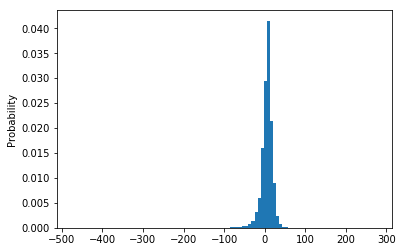

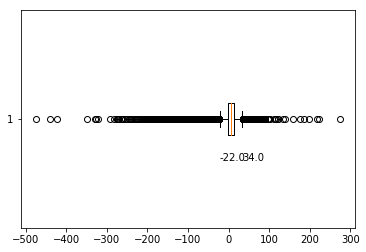

In [11]:
df_reduced['TURNOVER_TIME'] = (df_reduced['DEP_DELAY'] - df_reduced['ARR_DELAY'])
plt.hist(df_reduced['TURNOVER_TIME'], normed=True, bins=100)
plt.ylabel('Probability');

fig1, ax1 = plt.subplots()
bp_dict = ax1.boxplot(df_reduced['TURNOVER_TIME'], vert=False)

for line in bp_dict['whiskers']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y-.2, '%.1f' % x, horizontalalignment='left', verticalalignment = 'bottom') # draw above, centered
plt.show()

There are many outliers based on the boxplot, so let's limit the results using the 1.5 quartile range rule. According to the boxplot above, the interquartile range is 22-(-34) = 56 --> 1.5 * 56 = 84 --> upper bound = 22 + 84 = 106 and lower bound = -34 - 84 = -118. 

In [12]:
print(len(df_reduced))
df_reduced = df_reduced.loc[(df_reduced['TURNOVER_TIME']<=106)&(df_reduced['TURNOVER_TIME']>=-118),:]
print(len(df_reduced))

7071818
7070284


We see that there are no outliers in the greater than 1.5 interquartile adjustment. Let's check for any time-series trends in the data using the columns we created earlier.

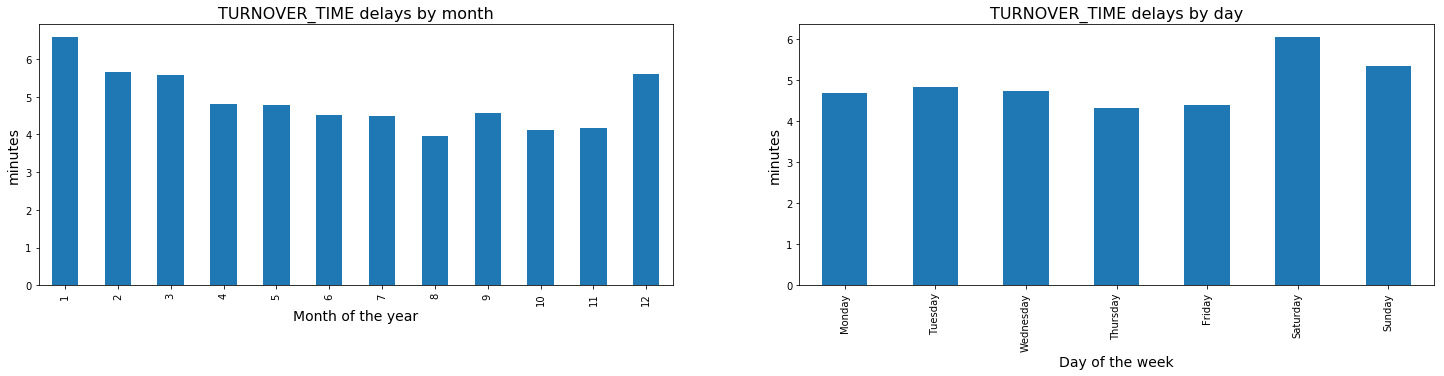

In [13]:
# Arrival and departure delays by month of the year
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

plt.subplot(2, 2 ,1)
df_reduced.groupby('FL_DATE_month').TURNOVER_TIME.mean().plot.bar().set_title('ARRIVAL delays by month')
plt.title('TURNOVER_TIME delays by month', fontsize=16)
plt.ylabel('minutes', fontsize=14)
plt.xlabel('Month of the year', fontsize=14)

plt.subplot(2, 2 ,2)
df_reduced.groupby('FL_DATE_weekday', sort=False).TURNOVER_TIME.mean().plot.bar()
plt.title('TURNOVER_TIME delays by day', fontsize=16)
plt.ylabel('minutes', fontsize=14)
plt.xlabel('Day of the week', fontsize=14)

plt.show()

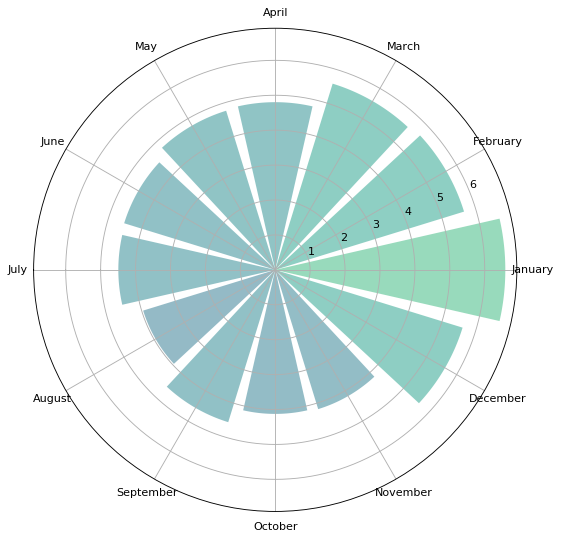

In [14]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

## Compute pie slices
N = 12
theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)
radii = df_reduced.groupby('FL_DATE_month', sort=False).TURNOVER_TIME.mean()
width = np.pi/7
colors = plt.cm.viridis(radii / 10.)


ax = plt.subplot(111, projection='polar')
ticklabels = ['July','June','May','April','March','February','January','December','November','October','September','August']
ax.set_xticklabels(ticklabels)
ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 12, endpoint=False))
ax.set_thetalim(-np.pi, np.pi)
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)

plt.show()

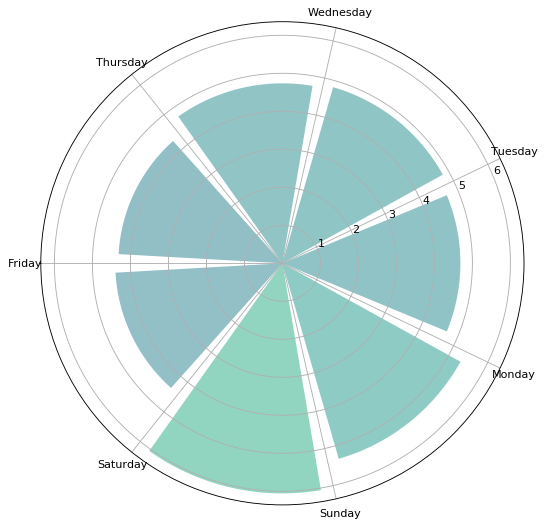

In [15]:
## Compute pie slices
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

N = 7
theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)
radii = df_reduced.groupby('FL_DATE_weekday', sort=False).TURNOVER_TIME.mean()
width = np.pi/4
colors = plt.cm.viridis(radii / 10.)


ax = plt.subplot(111, projection='polar')
ticklabels = ['Friday','Thursday','Wednesday','Tuesday','Monday','Sunday','Saturday']
ax.set_xticklabels(ticklabels)
ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 7, endpoint=False))
ax.set_thetalim(-np.pi, np.pi)
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)

plt.show()

As we can see, Month of the year plays a much larger role than time of week, with winter seasons slowing down the turnover time. Let's add in a couple factors to account for the high traffic times. The factors will be (binary):
- is_high_travel_day (
- is_holiday
- and is_summer.

bank holidays in 2018:
- January 1, 2018	New Year’s Day	Monday
- January 15, 2018	Martin Luther King, Jr.’s Birthday	Monday
- February 19, 2018	Washington’s Birthday/President’s Day	Monday
- May 28, 2018	Memorial Day	Monday
- July 4, 2018	Independence Day	Wednesday
- September 3, 2018	Labor Day	Monday
- October 8, 2018	Columbus Day	Monday
- November 12, 2018	Veterans Day	Monday
- November 22, 2018	Thanksgiving Day	Thursday
- December 25, 2018	Christmas Day	Tuesday

0    3903002
1    3167282
Name: high_travel_days, dtype: int64
0    4591357
1    2478927
Name: is_summer, dtype: int64
0    6848309
1     221975
Name: is_holiday, dtype: int64


Text(0.5, 0, 'is_holiday')

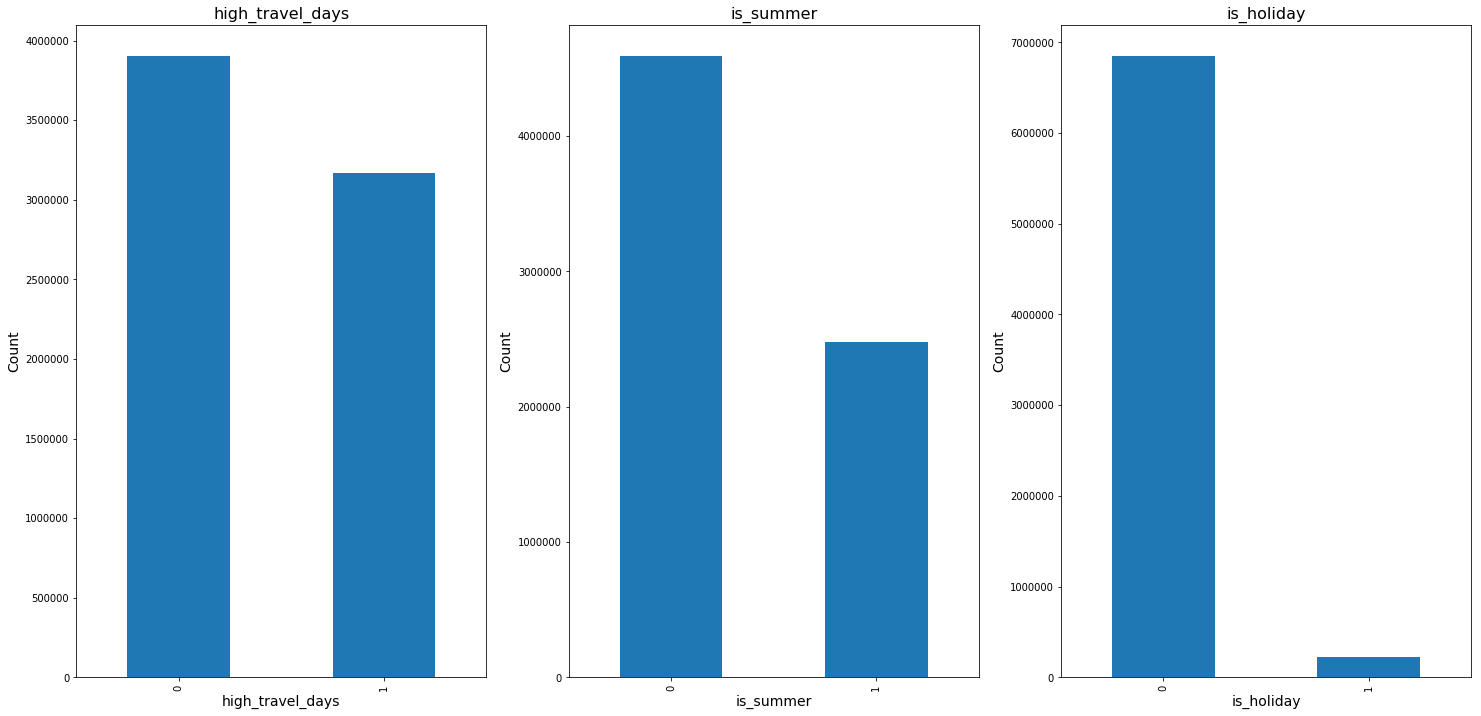

In [16]:
# high_travel_days
temp_1 = {'Friday':1, 'Monday':1, 'Thursday':1, 'Sunday':0, 'Tuesday':0, 'Wednesday':0, 'Saturday':0}
df_reduced['high_travel_days'] = df_reduced['FL_DATE_weekday'].map(temp_1)
print(df_reduced['high_travel_days'].value_counts())

# is_summer
temp_2 = {1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:0, 10:0, 11:0, 12:0}
df_reduced['is_summer'] = df_reduced['FL_DATE_month'].map(temp_2)
print(df_reduced['is_summer'].value_counts())

# is_holiday - people will fly out around the holidays to get a long weekend
date_list = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03',
             '2018-10-08','2018-11-12','2018-11-22','2018-11-21','2018-12-25','2018-12-26']
df_reduced['is_holiday'] = 0
df_reduced.loc[df_reduced['FL_DATE'].isin(date_list), 'is_holiday'] = 1
print(df_reduced['is_holiday'].value_counts())

plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)
plt.subplot(1, 3 ,1)
df_reduced['high_travel_days'].value_counts().plot.bar().set_title('ARRIVAL delays by month')
plt.title('high_travel_days', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('high_travel_days', fontsize=14)

plt.subplot(1, 3 ,2)
df_reduced['is_summer'].value_counts().plot.bar().set_title('ARRIVAL delays by month')
plt.title('is_summer', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('is_summer', fontsize=14)

plt.subplot(1, 3 ,3)
df_reduced['is_holiday'].value_counts().plot.bar().set_title('ARRIVAL delays by month')
plt.title('is_holiday', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('is_holiday', fontsize=14)

Let's compare the TURNOVER_TIME for each:

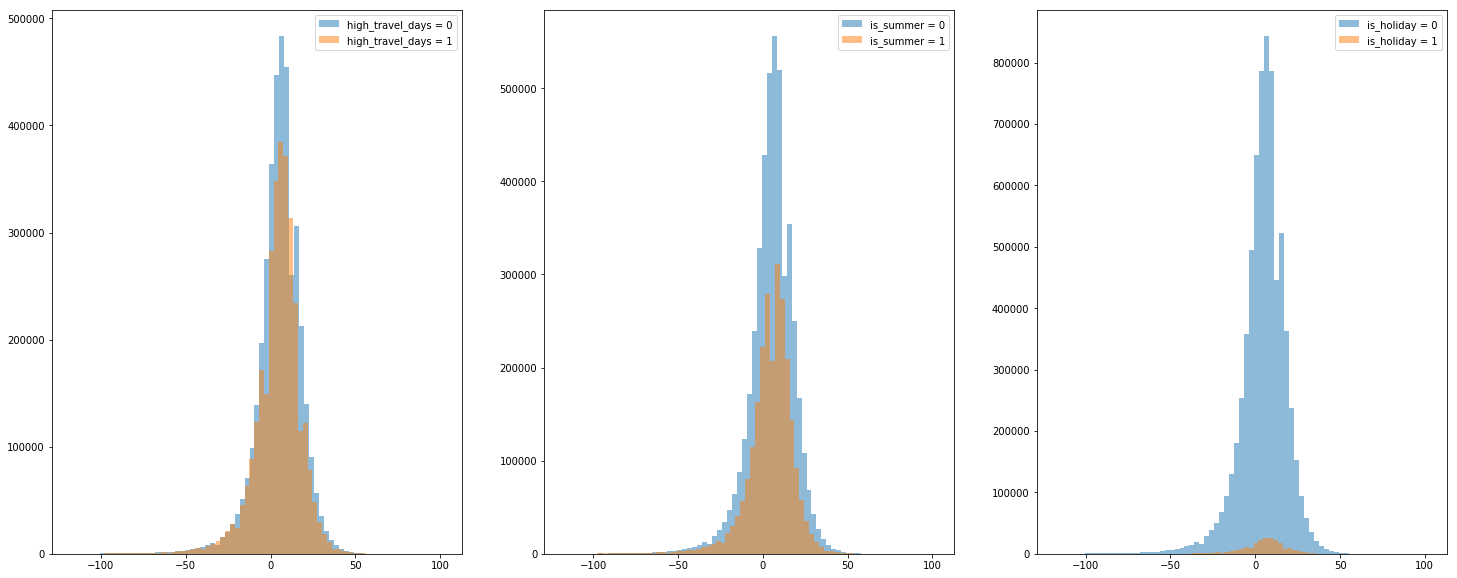

In [17]:

temp1 = df_reduced.loc[df_reduced['high_travel_days'] == 0].TURNOVER_TIME
temp2 = df_reduced.loc[df_reduced['high_travel_days'] == 1].TURNOVER_TIME

plt.figure(figsize=(25, 10)).subplots_adjust(hspace = 0.5)
plt.subplot(1, 3 ,1)
plt.hist(temp1,75, alpha=0.5, label='high_travel_days = 0')
plt.hist(temp2,75, alpha=0.5, label='high_travel_days = 1')
plt.legend(loc='upper right')

temp3 = df_reduced.loc[df_reduced['is_summer'] == 0].TURNOVER_TIME
temp4 = df_reduced.loc[df_reduced['is_summer'] == 1].TURNOVER_TIME
plt.subplot(1, 3 ,2)
plt.hist(temp3,75, alpha=0.5, label='is_summer = 0')
plt.hist(temp4,75, alpha=0.5, label='is_summer = 1')
plt.legend(loc='upper right')

temp5 = df_reduced.loc[df_reduced['is_holiday'] == 0].TURNOVER_TIME
temp6 = df_reduced.loc[df_reduced['is_holiday'] == 1].TURNOVER_TIME
plt.subplot(1, 3 ,3)
plt.hist(temp5,75, alpha=0.5, label='is_holiday = 0')
plt.hist(temp6,75, alpha=0.5, label='is_holiday = 1')
plt.legend(loc='upper right')

plt.show()

Although these distributions look awefully similar, let's double check using a z-test. I'm having trouble loading scipy, so let's write a function to run a z-test.

In [18]:
t ,pval = stats.ttest_ind(list(temp1.values), list(temp1.values-1), equal_var= False)
print('high_travel_days:')
print('t: ',t,'p-value: ', pval)
print('high_travel_days = 0 - ','Mean: ', temp1.mean(), 'StDev: ', temp1.std(), 'Samples: ', len(temp1))
print('high_travel_days = 1 - ','Mean: ', temp2.mean(), 'StDev: ', temp2.std(), 'Samples: ', len(temp2))
if pval<0.05:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')

high_travel_days:
t:  104.93345927806602 p-value:  0.0
high_travel_days = 0 -  Mean:  5.2093883118686595 StDev:  13.31283038622447 Samples:  3903002
high_travel_days = 1 -  Mean:  4.467278884545172 StDev:  13.504725240183886 Samples:  3167282
reject null hypothesis


In [19]:
t ,pval = stats.ttest_ind(list(temp3.values), list(temp4.values-1), equal_var= False)
print('is_summer:')
print('t: ',t,'p-value: ', pval)
print('is_summer = 0 - ','Mean: ', temp3.mean(), 'StDev: ', temp3.std(), 'Samples: ', len(temp3))
print('is_summer = 1 - ','Mean: ', temp4.mean(), 'StDev: ', temp4.std(), 'Samples: ', len(temp4))
if pval<0.05:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')

is_summer:
t:  158.25737570259236 p-value:  0.0
is_summer = 0 -  Mean:  5.116780725175586 StDev:  13.28069609311256 Samples:  4591357
is_summer = 1 -  Mean:  4.432731581042927 StDev:  13.618882490777796 Samples:  2478927
reject null hypothesis


In [20]:
t ,pval = stats.ttest_ind(list(temp5.values), list(temp6.values-1), equal_var= False)
print('is_holiday:')
print('t: ',t,'p-value: ', pval)
print('is_holiday = 0 - ','Mean: ', temp5.mean(), 'StDev: ', temp5.std(), 'Samples: ', len(temp5))
print('is_holiday = 1 - ','Mean: ', temp6.mean(), 'StDev: ', temp6.std(), 'Samples: ', len(temp6))
if pval<0.05:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')

is_holiday:
t:  41.44239921115523 p-value:  0.0
is_holiday = 0 -  Mean:  4.885293581232973 StDev:  13.37793110014802 Samples:  6848309
is_holiday = 1 -  Mean:  4.619371550850321 StDev:  14.188798251782586 Samples:  221975
reject null hypothesis


# Does carrier make a difference?

WN    1331506
DL     943676
AA     899113
OO     760662
UA     614751
YX     305143
B6     297674
MQ     284438
OH     265733
AS     242960
9E     231746
YV     209051
EV     196553
NK     174086
F9     117491
G4      95174
HA      83375
VX      17152
Name: OP_CARRIER, dtype: int64


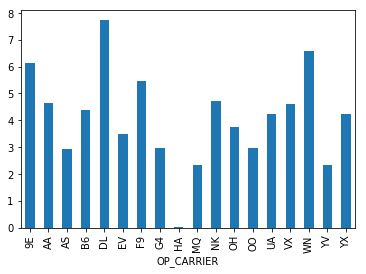

In [21]:
print(df_reduced['OP_CARRIER'].value_counts())

df_reduced.groupby('OP_CARRIER').TURNOVER_TIME.mean().plot.bar()

Last sanity check:

In [22]:
df_final = df_reduced.copy()
df_final = df_final.drop(columns=['ARR_DELAY', 'DEP_DELAY'])
print(df_final.columns)
df_final.describe()

Index(['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'ARR_TIME', 'DISTANCE',
       'FL_DATE_month', 'FL_DATE_weekday', 'TURNOVER_TIME', 'high_travel_days',
       'is_summer', 'is_holiday'],
      dtype='object')


,ARR_TIME,DISTANCE,FL_DATE_month,TURNOVER_TIME,high_travel_days,is_summer,is_holiday
count,7.070284e+06,7.070284e+06,7.070284e+06,7.070284e+06,7.070284e+06,7.070284e+06,7.070284e+06
mean,1.466725e+03,8.026080e+02,6.581696e+00,4.876945e+00,4.479710e-01,3.506121e-01,3.139549e-02
std,5.373738e+02,5.994235e+02,3.394535e+00,1.340421e+01,4.972856e-01,4.771617e-01,1.743841e-01
min,1.000000e+00,3.100000e+01,1.000000e+00,-1.180000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.048000e+03,3.630000e+02,4.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.506000e+03,6.340000e+02,7.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.916000e+03,1.035000e+03,1.000000e+01,1.300000e+01,1.000000e+00,1.000000e+00,0.000000e+00
max,2.400000e+03,4.983000e+03,1.200000e+01,1.020000e+02,1.000000e+00,1.000000e+00,1.000000e+00


In [23]:
corr = df_final.corr(method ='pearson')
corr.style.background_gradient(cmap='coolwarm')

,ARR_TIME,DISTANCE,FL_DATE_month,TURNOVER_TIME,high_travel_days,is_summer,is_holiday
ARR_TIME,1,0.00653829,-0.00261477,-0.0103701,-0.00471214,-0.0216719,-0.00110895
DISTANCE,0.00653829,1,8.96848e-05,0.0989801,-0.00703364,0.0108081,0.00284512
FL_DATE_month,-0.00261477,8.96848e-05,1,-0.0330127,-0.00396038,-0.0139143,0.0558802
TURNOVER_TIME,-0.0103701,0.0989801,-0.0330127,1,-0.0275317,-0.0243507,-0.00345955
high_travel_days,-0.00471214,-0.00703364,-0.00396038,-0.0275317,1,-0.00109636,0.0804527
is_summer,-0.0216719,0.0108081,-0.0139143,-0.0243507,-0.00109636,1,-0.0706376
is_holiday,-0.00110895,0.00284512,0.0558802,-0.00345955,0.0804527,-0.0706376,1


In [24]:
df_with_weather = df_final.copy()

# Build a Model

My goal of doing these classes was to learn PyTorch, so although I imagine a random forrest would do quite well, I plan on implementig a regression NN. I may implement a random forrest later on to compare the outputs or if this model does not achieve great accuracy.

In [25]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import preprocessing
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt

class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

def split_data(df):    
    msk = np.random.rand(len(df)) < .8
    train_raw = df[msk].copy()
    test_raw = df[~msk].copy()
    return train_raw, test_raw

def dataprep_ohe(df,ohe):
    numerical = list(set(df.columns.values) - set(ohe))
    temp = df[numerical].copy()
    df = pd.concat([temp,pd.get_dummies(df[ohe])], axis=1)
    print(df.columns)
    return df
    
def dataprep_stsc(df,stsc):
    ss_col = df[stsc].copy()
    scaler = preprocessing.StandardScaler().fit(ss_col.values)
    features = scaler.transform(ss_col.values)
    df[stsc] = features
    return df

def categorize_dtype(df, cols):
    for category in cols:
        df[category] = df[category].astype('category')
    return df



In [26]:
raw_data = df_final.copy().head(1000000)

numerical_columns = ['ARR_TIME','DISTANCE']
ohe = ['OP_CARRIER','ORIGIN', 'DEST', ]
categorical_columns = ['high_travel_days','is_summer','is_holiday','FL_DATE_month','FL_DATE_weekday']

raw_data.loc[raw_data.high_travel_days == 0, 'high_travel_days'] = -1
raw_data.loc[raw_data.is_summer == 0, 'is_summer'] = -1
raw_data.loc[raw_data.is_holiday == 0, 'is_holiday'] = -1
raw_data = categorize_dtype(raw_data,categorical_columns)
raw_data = dataprep_stsc(raw_data,numerical_columns)

cat1 = raw_data['high_travel_days'].cat.codes.values
cat2 = raw_data['is_summer'].cat.codes.values
cat3 = raw_data['is_holiday'].cat.codes.values
cat4 = raw_data['FL_DATE_month'].cat.codes.values
cat5 = raw_data['FL_DATE_weekday'].cat.codes.values

categorical_data = np.stack([cat1, cat2, cat3, cat4, cat5], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

numerical_data = np.stack([raw_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

output = raw_data.pop('TURNOVER_TIME')
outputs = torch.tensor(output.values).flatten().float() 

print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

torch.Size([1000000, 5])
torch.Size([1000000, 2])
torch.Size([1000000])


In [27]:
categorical_column_sizes = [len(raw_data[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

total_records = len(raw_data)
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

print(categorical_train_data.shape)
print(categorical_test_data.shape)
print(numerical_train_data.shape)
print(numerical_test_data.shape)
print(train_outputs.shape)
print(test_outputs.shape)

torch.Size([800000, 5])
torch.Size([200000, 5])
torch.Size([800000, 2])
torch.Size([200000, 2])
torch.Size([800000])
torch.Size([200000])


In [28]:
#__init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4)
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 1, [100,50,10], p=0.4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(1, 1)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
    (4): Embedding(7, 4)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=10, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
   

In [29]:
epochs = 10
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    y_pred = torch.flatten(y_pred)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    #if i%25 == 1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 233.77224731
epoch:   2 loss: 233.35127258
epoch:   3 loss: 232.94834900
epoch:   4 loss: 232.61434937
epoch:   5 loss: 232.28895569
epoch:   6 loss: 231.96519470
epoch:   7 loss: 231.71147156
epoch:   8 loss: 231.46664429
epoch:   9 loss: 231.21232605
epoch:  10 loss: 231.01524353
epoch:  10 loss: 231.0152435303


Loss: 246.07218933


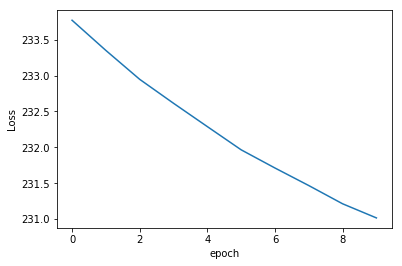

In [30]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    y_val = torch.flatten(y_val)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

# Add Weather Data

In [31]:
list_orig = df_with_weather.ORIGIN.unique()
list_dest = df_with_weather.DEST.unique()
print(list(set(list_orig) - set(list_dest)))

[]


In [32]:
cols = ['city','state','code']
city_codes = pd.read_csv(r'raw_data\airport_codes_wikipedia.csv', usecols = ['City','FAA'])
print(city_codes.head())

           City  FAA
0    Morgantown  MGW
1        Sidney  SDY
2        Alpena  APN
3        Marion  MWA
4  Provincetown  PVC


In [33]:
city_code_dict = pd.Series(city_codes['City'].values,index=city_codes['FAA']).to_dict()


In [34]:

df_with_weather['origin_city'] = df_with_weather['ORIGIN'].map(city_code_dict).str.upper() 
df_with_weather['destination_city'] = df_with_weather['DEST'].map(city_code_dict).str.upper()

print(df_with_weather.ORIGIN.isna().sum())
print(df_with_weather.DEST.isna().sum())

print(df_with_weather.origin_city.isna().sum())
print(df_with_weather.destination_city.isna().sum())

0
0
58948
59090


In [35]:
temp_df_orig = df_with_weather[['ORIGIN','origin_city']].copy()
temp_df_dest = df_with_weather[['DEST','destination_city']].copy()
print(len(temp_df_orig),len(temp_df_dest))
temp_df_orig = temp_df_orig[temp_df_orig.isnull().any(axis=1)]
temp_df_dest = temp_df_dest[temp_df_dest.isnull().any(axis=1)]

print(temp_df_orig.ORIGIN.unique())
print(temp_df_dest.DEST.unique())


7070284 7070284
['SJU' 'GUM' 'STX' 'BQN' 'PSE' 'STT' 'USA' 'AZA' 'FCA' 'PPG' 'MQT' 'SWO'
 'YUM' 'MEI' 'PIB' 'SCE' 'ISN' 'PUB' 'CGI' 'UIN' 'DVL' 'JMS' 'HYS' 'OGS'
 'ADK' 'BFF' 'LBF' 'LBL' 'LWB' 'SHD' 'SLN' 'CNY' 'WYS' 'SPN' 'GST' 'BKG'
 'VEL' 'HHH' 'PRC' 'EAR' 'DRT' 'CYS']
['SJU' 'GUM' 'STX' 'BQN' 'PSE' 'STT' 'USA' 'AZA' 'FCA' 'PPG' 'MQT' 'SWO'
 'YUM' 'MEI' 'PIB' 'SCE' 'ISN' 'PUB' 'UIN' 'CGI' 'JMS' 'DVL' 'HYS' 'OGS'
 'ADK' 'BFF' 'LBF' 'LBL' 'SHD' 'LWB' 'SLN' 'CNY' 'WYS' 'SPN' 'GST' 'BKG'
 'VEL' 'HHH' 'PRC' 'EAR' 'DRT' 'CYS']


In [36]:
df_with_weather = df_with_weather.dropna()
all_cities = df_with_weather.origin_city.unique()

In [37]:
cols = ['station_code', 'city']
weather_station_codes = pd.read_csv(r'raw_data\station_codes.csv',header=None, usecols = [3,4], names = cols)
weather_station_codes = weather_station_codes.dropna()
weather_station_codes.to_csv('temp.csv')

weather_station_dict = pd.Series(weather_station_codes['station_code'].values,index=weather_station_codes['city']).to_dict()

print(weather_station_dict)

{'ABBEVILLE': 'USC00220008', 'ADDISON': 'USC00300023', 'ALABASTER SHELBY CO AP': 'USW00053864', 'ALBERTA': 'USC00010140', 'ALEXANDER CITY': 'USC00010160', 'ALICEVILLE': 'USC00010178', 'ALICEVILLE L&D': 'USC00010184', 'LEXINGTON': 'USC00444876', 'ANNISTON ARPT ASOS': 'USW00013871', 'ASHLAND': 'USC00440327', 'ASHVILLE 4 SW': 'USC00010378', 'ATHENS': 'USC00410404', 'ATMORE': 'USC00010402', 'AUBURN NO.2': 'USC00010425', 'BANKHEAD L&D': 'USC00010505', 'BAY MINETTE': 'USC00010583', 'BELLE MINA 2 N': 'USC00010655', 'BERRY 3 NW': 'USC00010748', 'BESSEMER 3 WSW': 'USC00010764', 'BILLINGSLEY': 'USC00010823', 'BIRMINGHAM AP ASOS': 'USW00013876', 'BOAZ': 'USC00010957', 'BREWTON 3 ENE': 'USC00011080', 'BRIDGEPORT 5 NW': 'USC00011099', 'BRIERFIELD': 'USC00011100', 'CAHABA PUMP HOUSE': 'USC00011225', 'CALERA': 'USC00011288', 'CENTRE': 'USC00011490', 'CENTREVILLE 2.9 SW': 'USW00003881', 'CHATOM': 'USC00011566', 'CHILDERSBURG WTP': 'USC00011620', 'CLAIBORNE L&D': 'USC00011690', 'CLANTON': 'USC00011694'

In [38]:
print(df_with_weather.head())

      FL_DATE OP_CARRIER ORIGIN DEST  ARR_TIME  DISTANCE  FL_DATE_month FL_DATE_weekday  TURNOVER_TIME  high_travel_days  is_summer  is_holiday        origin_city destination_city
0  2018-01-01         UA    EWR  DEN    1722.0    1605.0              1          Monday           18.0                 1          0           1  NEW YORK / NEWARK           DENVER
1  2018-01-01         UA    LAS  SFO    1230.0     414.0              1          Monday           16.0                 1          0           1          LAS VEGAS    SAN FRANCISCO
2  2018-01-01         UA    SNA  DEN    1636.0     846.0              1          Monday            8.0                 1          0           1      ORANGE COUNTY           DENVER
3  2018-01-01         UA    RSW  ORD    1754.0    1120.0              1          Monday            8.0                 1          0           1         FORT MYERS          CHICAGO
4  2018-01-01         UA    ORD  ALB     936.0     723.0              1          Monday            6

In [39]:
print(all_cities)

['NEW YORK\xa0/\xa0NEWARK' 'LAS VEGAS' 'ORANGE COUNTY' 'FORT MYERS'
 'CHICAGO' 'HOUSTON' 'DENVER' 'SACRAMENTO' 'RICHMOND' 'PORTLAND' 'ORLANDO'
 'KNOXVILLE' 'SAN FRANCISCO' 'JACKSON HOLE' 'BOSTON' 'NEW ORLEANS' 'MIAMI'
 'SEATTLE\xa0/\xa0TACOMA\xa0(SEATAC)' 'SAN ANTONIO' 'SALT LAKE CITY'
 'RALEIGH' 'FORT LAUDERDALE'
 'WASHINGTON, D.C.\xa0/\xa0DULLES\xa0/\xa0CHANTILLY' 'DALLAS' 'ANCHORAGE'
 'MINNEAPOLIS' 'ALBANY' 'LOS ANGELES' 'INDIANAPOLIS' 'SAN DIEGO'
 'NASHVILLE' 'HARTFORD' 'ALBUQUERQUE' 'SAVANNAH' 'PHOENIX' 'AUSTIN'
 'PHILADELPHIA' 'SAN JOSE' 'NORFOLK'
 'WASHINGTON, D.C.\xa0/\xa0ARLINGTON COUNTY' 'NEW YORK' 'BALTIMORE'
 'PITTSBURGH' 'KAHULUI, MAUI' 'CLEVELAND' 'TAMPA' 'MYRTLE BEACH'
 'ROCHESTER' 'EAGLE/VAIL' 'HONOLULU, OAHU' 'ONTARIO' 'WEST PALM BEACH'
 'MILWAUKEE' 'HAYDEN' 'JACKSONVILLE' 'OKLAHOMA CITY' 'ATLANTA' 'SARASOTA'
 'BOZEMAN' 'EUGENE' 'BOISE' 'RENO' 'SPOKANE' 'TUCSON' 'LIHUE, KAUAI'
 'KAILUA-KONA, HAWAII' 'HILO, HAWAII' 'PALM SPRINGS' 'DETROIT' 'GUNNISON'
 'OMAHA' 'MONTROSE'

In [40]:
correction_dict = {'NEW YORK\xa0/\xa0NEWARK':'New York'
                  ,'SEATTLE\xa0/\xa0TACOMA\xa0(SEATAC)':'Seattle'
                  ,'CINCINNATI/COVINGTON':'Cincinatti'
                  ,'TRI-CITIES':'Kennewick'
                  ,'D.C.\xa0/\xa0DULLES\xa0/\xa0CHANTILLY':'Chantilly'
                  ,'GULFPORT\xa0/\xa0BILOXI':'Boloxi'
                  ,'ARCATA/EUREKA':'EUREKA'
                  }

df_with_weather['origin_city'] = df_with_weather['origin_city'].replace(correction_dict).str.upper() 
df_with_weather['destination_city'] = df_with_weather['destination_city'].replace(correction_dict).str.upper() 

all_cities = df_with_weather.origin_city.unique()
print(all_cities)

['NEW YORK' 'LAS VEGAS' 'ORANGE COUNTY' 'FORT MYERS' 'CHICAGO' 'HOUSTON'
 'DENVER' 'SACRAMENTO' 'RICHMOND' 'PORTLAND' 'ORLANDO' 'KNOXVILLE'
 'SAN FRANCISCO' 'JACKSON HOLE' 'BOSTON' 'NEW ORLEANS' 'MIAMI' 'SEATTLE'
 'SAN ANTONIO' 'SALT LAKE CITY' 'RALEIGH' 'FORT LAUDERDALE'
 'WASHINGTON, D.C.\xa0/\xa0DULLES\xa0/\xa0CHANTILLY' 'DALLAS' 'ANCHORAGE'
 'MINNEAPOLIS' 'ALBANY' 'LOS ANGELES' 'INDIANAPOLIS' 'SAN DIEGO'
 'NASHVILLE' 'HARTFORD' 'ALBUQUERQUE' 'SAVANNAH' 'PHOENIX' 'AUSTIN'
 'PHILADELPHIA' 'SAN JOSE' 'NORFOLK'
 'WASHINGTON, D.C.\xa0/\xa0ARLINGTON COUNTY' 'BALTIMORE' 'PITTSBURGH'
 'KAHULUI, MAUI' 'CLEVELAND' 'TAMPA' 'MYRTLE BEACH' 'ROCHESTER'
 'EAGLE/VAIL' 'HONOLULU, OAHU' 'ONTARIO' 'WEST PALM BEACH' 'MILWAUKEE'
 'HAYDEN' 'JACKSONVILLE' 'OKLAHOMA CITY' 'ATLANTA' 'SARASOTA' 'BOZEMAN'
 'EUGENE' 'BOISE' 'RENO' 'SPOKANE' 'TUCSON' 'LIHUE, KAUAI'
 'KAILUA-KONA, HAWAII' 'HILO, HAWAII' 'PALM SPRINGS' 'DETROIT' 'GUNNISON'
 'OMAHA' 'MONTROSE' 'CHARLOTTE' 'CHARLESTON' 'KANSAS CITY' 'BILLINGS'
 'C

In [41]:
double_check_dict = {}
fuzzy_match_dict = {}
strOptions = list(weather_station_codes.city)
for city in all_cities:
    result = process.extractOne(city,strOptions)
    print(city,result)
    fuzzy_match_dict[city] = str(result[0])
    if result[1] < 90:
        double_check_dict[city] = str(result)

NEW YORK ('NEW YORK MILLS', 90)
LAS VEGAS ('LAS VEGAS WFO', 95)
ORANGE COUNTY ('RANGE', 90)
FORT MYERS ('FT MYERS PAGE FLD AP', 86)
CHICAGO ("CHICAGO O'HARE AP", 90)
HOUSTON ('HOUSTON', 100)
DENVER ('DENVER', 100)
SACRAMENTO ('SACRAMENTO AP ASOS', 90)
RICHMOND ('RICHMOND', 100)
PORTLAND ('PORTLAND', 100)
ORLANDO ('ORLANDO W', 95)
KNOXVILLE ('KNOXVILLE', 100)
SAN FRANCISCO ('SAN FRANCISCO DWTN', 95)
JACKSON HOLE ('JACKSON', 90)
BOSTON ('BOSTON', 100)
NEW ORLEANS ('NEW ORLEANS AP', 95)
MIAMI ('MIAMI', 100)
SEATTLE ('SEATTLE SAND PT WFO', 90)
SAN ANTONIO ("SAN ANTONIO INT'L AP", 90)
SALT LAKE CITY ('LAKE CITY', 90)
RALEIGH ('RALEIGH 6N', 95)
FORT LAUDERDALE ('FT LAUDERDALE', 93)
WASHINGTON, D.C. / DULLES / CHANTILLY ('WASHINGTON', 90)
DALLAS ('DALLAS 7 NE', 90)
ANCHORAGE ('ANCHORAGE FORECAST OFFICE', 90)
MINNEAPOLIS ('MINNEAPOLIS', 100)
ALBANY ('ALBANY', 100)
LOS ANGELES ('LOS ANGELES INTL AP', 90)
INDIANAPOLIS ('INDIANAPOLIS NWFO', 95)
SAN DIEGO ('SAN DIEGO INTL AP', 90)
NASHVILLE ('NASH

MAMMOTH LAKES ('MAMMOTH LAKES RS', 95)
LEWISTON ('LEWISTON', 100)
POCATELLO ('POCATELLO CITY', 90)
ABERDEEN ('ABERDEEN', 100)
ALPENA ('ALPENA CO RGNL AP', 90)
ESCANABA ('ESCANABA', 100)
PELLSTON ('PELLSTON RGNL AP', 90)
BEMIDJI ('BEMIDJI', 100)
BUTTE ('BUTTE', 100)
CEDAR CITY ('CEDAR CITY', 100)
SAULT STE. MARIE ('SAULT STE MARIE', 97)
ELKO ('ELKO NWS OFFICE', 90)
HIBBING ('KING', 68)
BINGHAMTON ('BINGHAMTON WFO', 95)
RHINELANDER ('RHINELANDER', 100)
BRAINERD ('BRAINERD', 100)
INTERNATIONAL FALLS ('INTERNATIONAL FALLS AP', 95)
BROWNSVILLE ('BROWNSVILLE', 100)
LAREDO ('LAREDO 2', 95)
OGDEN ('OGDEN', 100)
PROVO ('PROVO BYU', 90)
PORTSMOUTH ('PORTSMOUTH-SCIOTOVILLE', 90)
HANCOCK ('HANCOCK', 100)
MUSKEGON ('MUSKEGON CO AP', 90)
PADUCAH ('PADUCAH', 100)
YAKUTAT ('YAKUTAT AP', 95)
CORDOVA ('CORDOVA N', 95)
WRANGELL ('RANGE', 90)
PETERSBURG ('PETERSBURG', 100)
ST. CLOUD ('BODIE CALIFORNIA ST HISTORIC P', 86)
LYNCHBURG ('LYNCHBURG', 100)
FLORENCE ('FLORENCE', 100)
NANTUCKET ('NANTUCKET COOP', 

In [42]:
for item in double_check_dict:
    print(item, double_check_dict[item])

FORT MYERS ('FT MYERS PAGE FLD AP', 86)
KAHULUI, MAUI ('KAPALUA-W MAUI AP 462.4', 86)
HONOLULU, OAHU ('HONOLULU OBSERV. 702.2', 86)
SARASOTA ('WASTA', 72)
LIHUE, KAUAI ('LIHUE VRTY STN 1062.1', 86)
KAILUA-KONA, HAWAII ('KAILUA 446', 86)
HILO, HAWAII ('HAWAII VOL NP HQ 54', 86)
CINCINATTI ('CINCINNATI/NORTHERN KENTUCKY I', 81)
ST. LOUIS ('BODIE CALIFORNIA ST HISTORIC P', 86)
FORT SMITH ('FT SMITH RGNL AP', 86)
MOSINEE ('MONTEREY', 67)
KILLEEN ('KILLDEER', 80)
BOLOXI ('BILOXI', 83)
COLLEGE STATION ('ANGWIN PACIFIC UNION COLLEGE', 86)
NIAGARA FALLS ('TAHQUAMENON FALLS SP', 86)
KALAMAZOO ('LAMAR', 72)
LATROBE ('TROY', 68)
NEW HAVEN ('E HAVEN', 88)
PASCO ('WASCO', 80)
IRON MOUNTAIN ('IRON MTN', 86)
TWIN FALLS ('TWIN LAKES RSVR', 86)
HIBBING ('KING', 68)
ST. CLOUD ('BODIE CALIFORNIA ST HISTORIC P', 86)
DILLINGHAM ('DILLON', 75)


For ones that don't match well, just point it towards the closest major city because the weather will be very similar:

In [43]:
fuzzy_match_dict['ST. LOUIS'] = 'ST LOUIS LAMBERT INTL AIRPORT'
fuzzy_match_dict['COLLEGE STATION'] = 'HOUSTON BUSH INTL AP'
fuzzy_match_dict['MOSINEE'] = 'MADISON DANE CO AP'
fuzzy_match_dict['KILLEEN'] = 'AUSTIN-CAMP MABRY'
fuzzy_match_dict['NIAGARA FALLS'] = 'BUFFALO NIAGARA INTL'
fuzzy_match_dict['LATROBE'] = 'PITTSBURGH ASOS'
fuzzy_match_dict['PASCO'] = 'SPOKANE INTL AP'
fuzzy_match_dict['TWIN FALLS'] = 'BOISE AIR TERMINAL'
fuzzy_match_dict['HIBBING'] = 'MINNEAPOLIS-ST PAUL INTL AP'
fuzzy_match_dict['ST. CLOUD'] = 'MINNEAPOLIS-ST PAUL INTL AP'
fuzzy_match_dict['DILLINGHAM'] = 'ANCHORAGE TED STEVENS INTL AP'

for item in fuzzy_match_dict:
    print(item, fuzzy_match_dict[item])

NEW YORK NEW YORK MILLS
LAS VEGAS LAS VEGAS WFO
ORANGE COUNTY RANGE
FORT MYERS FT MYERS PAGE FLD AP
CHICAGO CHICAGO O'HARE AP
HOUSTON HOUSTON
DENVER DENVER
SACRAMENTO SACRAMENTO AP ASOS
RICHMOND RICHMOND
PORTLAND PORTLAND
ORLANDO ORLANDO W
KNOXVILLE KNOXVILLE
SAN FRANCISCO SAN FRANCISCO DWTN
JACKSON HOLE JACKSON
BOSTON BOSTON
NEW ORLEANS NEW ORLEANS AP
MIAMI MIAMI
SEATTLE SEATTLE SAND PT WFO
SAN ANTONIO SAN ANTONIO INT'L AP
SALT LAKE CITY LAKE CITY
RALEIGH RALEIGH 6N
FORT LAUDERDALE FT LAUDERDALE
WASHINGTON, D.C. / DULLES / CHANTILLY WASHINGTON
DALLAS DALLAS 7 NE
ANCHORAGE ANCHORAGE FORECAST OFFICE
MINNEAPOLIS MINNEAPOLIS
ALBANY ALBANY
LOS ANGELES LOS ANGELES INTL AP
INDIANAPOLIS INDIANAPOLIS NWFO
SAN DIEGO SAN DIEGO INTL AP
NASHVILLE NASHVILLE
HARTFORD HARTFORD
ALBUQUERQUE ALBUQUERQUE FOOTHILLS NE
SAVANNAH SAVANNAH INTL AP
PHOENIX PHOENIX AP
AUSTIN PORT AUSTIN WWTP
PHILADELPHIA PHILADELPHIA 1 WSW
SAN JOSE SAN JOSE
NORFOLK NORFOLK AP
WASHINGTON, D.C. / ARLINGTON COUNTY WASHINGTON
BALTI

In [44]:
df_with_weather['origin_city'] = df_with_weather['origin_city'].replace(fuzzy_match_dict).str.upper() 
df_with_weather['destination_city'] = df_with_weather['destination_city'].replace(fuzzy_match_dict).str.upper()

In [45]:
print(df_with_weather['origin_city'].head(25))

0           NEW YORK MILLS
1            LAS VEGAS WFO
2                    RANGE
3     FT MYERS PAGE FLD AP
4        CHICAGO O'HARE AP
5        CHICAGO O'HARE AP
6                  HOUSTON
7                   DENVER
8       SACRAMENTO AP ASOS
9                 RICHMOND
10                PORTLAND
11       CHICAGO O'HARE AP
12          NEW YORK MILLS
13          NEW YORK MILLS
14       CHICAGO O'HARE AP
15               ORLANDO W
16          NEW YORK MILLS
17    FT MYERS PAGE FLD AP
18                 HOUSTON
19               KNOXVILLE
20          NEW YORK MILLS
21      SAN FRANCISCO DWTN
22    FT MYERS PAGE FLD AP
23      SAN FRANCISCO DWTN
24                 JACKSON
Name: origin_city, dtype: object


In [46]:
df_with_weather['origin_station_code'] = df_with_weather['origin_city'].map(weather_station_dict).str.upper()
df_with_weather['destination_station_code'] = df_with_weather['destination_city'].map(weather_station_dict).str.upper()

In [47]:
print(df_with_weather.head())

      FL_DATE OP_CARRIER ORIGIN DEST  ARR_TIME  DISTANCE  FL_DATE_month FL_DATE_weekday  TURNOVER_TIME  high_travel_days  is_summer  is_holiday           origin_city    destination_city origin_station_code destination_station_code
0  2018-01-01         UA    EWR  DEN    1722.0    1605.0              1          Monday           18.0                 1          0           1        NEW YORK MILLS              DENVER         USC00215902              USC00122166
1  2018-01-01         UA    LAS  SFO    1230.0     414.0              1          Monday           16.0                 1          0           1         LAS VEGAS WFO  SAN FRANCISCO DWTN         USC00264439              USW00023272
2  2018-01-01         UA    SNA  DEN    1636.0     846.0              1          Monday            8.0                 1          0           1                 RANGE              DENVER         USC00347412              USC00122166
3  2018-01-01         UA    RSW  ORD    1754.0    1120.0              1     

Sanity check to make sure that the cities (which had the same set for destination and origin) have led to equal sets for the airport codes.

In [48]:
list_orig = df_with_weather.origin_station_code.unique()
list_dest = df_with_weather.destination_station_code.unique()
print(list(set(list_orig) - set(list_dest)))

[]


In [49]:
print(list_dest)

['USC00122166' 'USW00023272' 'USW00094846' 'USC00410120' 'USC00035428'
 'USC00264439' 'USW00014990' 'USC00215902' 'USC00411810' 'USC00206690'
 'USC00410408' 'USC00471205' 'USW00023174' 'USW00023232' 'USC00484910'
 'USC00404945' 'USC00503731' 'USC00511918' 'USC00345855' 'USC00238746'
 'USC00427271' 'USW00012835' 'USC00083163' 'USW00023188' 'USC00214438'
 'USC00148847' 'USC00143248' 'USW00024221' 'USC00086634' 'USC00140313'
 'USW00094847' 'USC00401640' 'USW00014739' 'USW00023183' 'USW00024132'
 'USW00012916' 'USW00023293' 'USC00145363' 'USC00419593' 'USC00092485'
 'USW00012921' 'USC00206662' 'USC00124260' 'USC00088782' 'USC00226894'
 'USW00093721' 'USC00035112' 'USW00024162' 'USC00398911' 'USC00347412'
 'USC00227276' 'USC00053867' 'USW00094290' 'USC00046635' 'USC00173570'
 'USC00346659' 'USC00436893' 'USC00028795' 'USC00290225' 'USC00386153'
 'USC00512679' 'USC00513317' 'USC00414525' 'USC00515560' 'USC00481165'
 'USW00014941' 'USC00058575' 'USW00003822' 'USC00111436' 'USC00050754'
 'USW0

In [50]:
headers = {'token':'tZVpouYOrIcrLDPIUXCDbVCMJutlLQfA'}
startdate = '2018-01-01'
enddate = '2018-12-31'
limit = 1000
city = 'GHCND:USC00504094'
results = pd.DataFrame(columns = ['code','attributes','datatype','date','station','value'])

if not os.path.exists('scraped_weather_data.csv'):

    for code_primer in list_dest:
        code = 'GHCND:%s' % (code_primer)
        print(code_primer)
        try:
            url = 'http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=%s&startdate=%s&enddate=%s&limit=1000&includemetadata=false&datatypeid=PRCP&datatypeid=SNOW&units=metric' % (code,startdate,enddate)
            response = requests.get(url, headers = headers).json()
            response = json_normalize(response['results'])
            response['code'] = code_primer
            results = pd.concat([results,response])
        except:
            pass
    print(len(results))
    results.to_csv('scraped_weather_data.csv')
    
else:
    results = pd.read_csv('scraped_weather_data.csv')

In [51]:
print(results.head())

   Unnamed: 0 attributes         code datatype                 date            station  value
0           0   ,,W,2400  USW00023272     PRCP  2018-01-01T00:00:00  GHCND:USW00023272    0.0
1           1   ,,W,2400  USW00023272     PRCP  2018-01-02T00:00:00  GHCND:USW00023272    0.0
2           2   ,,W,2400  USW00023272     PRCP  2018-01-03T00:00:00  GHCND:USW00023272    2.3
3           3   ,,W,2400  USW00023272     PRCP  2018-01-04T00:00:00  GHCND:USW00023272    1.5
4           4   ,,W,2400  USW00023272     PRCP  2018-01-05T00:00:00  GHCND:USW00023272    6.6


In [52]:
print(results.dtypes)

Unnamed: 0      int64
attributes     object
code           object
datatype       object
date           object
station        object
value         float64
dtype: object


In [53]:
results['date'] =  pd.to_datetime(results['date'], format='%Y-%m-%d')
print(results['date'].head())

0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
Name: date, dtype: datetime64[ns]


# Combine Data

Now that we have the time formatting fixed, we are ready to split the results into rain and snow. We then join this weather information with the main datafram based on the date and station codes that we added to the main data.

In [54]:
final_data = df_with_weather.copy()
print(len(final_data))

6959173


In [55]:
snow_orig = results[results['datatype'] == 'PRCP'].copy()
rain_orig = results[results['datatype'] == 'SNOW'].copy()
snow_dest = results[results['datatype'] == 'PRCP'].copy()
rain_dest = results[results['datatype'] == 'SNOW'].copy()

snow_orig = snow_orig.rename(columns={"value": 'snow_amt_orig'
                            ,'code':'origin_station_code'
                            ,'date':'FL_DATE'})
rain_orig = rain_orig.rename(columns={"value": 'rain_amt_orig'
                            ,'code':'origin_station_code'
                            ,'date':'FL_DATE'})
snow_dest = snow_dest.rename(columns={"value": 'snow_amt_dest'
                            ,'code':'destination_station_code'
                            ,'date':'FL_DATE'})
rain_dest = rain_dest.rename(columns={"value": 'rain_amt_dest'
                            ,'code':'destination_station_code'
                            ,'date':'FL_DATE'})

snow_orig = snow_orig.drop(columns = ['attributes','station','datatype'])
rain_orig = rain_orig.drop(columns = ['attributes','station','datatype'])
snow_dest = snow_dest.drop(columns = ['attributes','station','datatype'])
rain_dest = rain_dest.drop(columns = ['attributes','station','datatype'])

print(snow_orig.head())
print(rain_dest.head())

   Unnamed: 0 origin_station_code    FL_DATE  snow_amt_orig
0           0         USW00023272 2018-01-01            0.0
1           1         USW00023272 2018-01-02            0.0
2           2         USW00023272 2018-01-03            2.3
3           3         USW00023272 2018-01-04            1.5
4           4         USW00023272 2018-01-05            6.6
     Unnamed: 0 destination_station_code    FL_DATE  rain_amt_dest
365           1              USW00094846 2018-01-01            0.0
367           3              USW00094846 2018-01-02            0.0
369           5              USW00094846 2018-01-03            3.0
371           7              USW00094846 2018-01-04            0.0
373           9              USW00094846 2018-01-05            0.0


In [56]:
print(final_data.dtypes)
final_data['FL_DATE'] =  pd.to_datetime(final_data['FL_DATE'], format='%Y-%m-%d')

FL_DATE                      object
OP_CARRIER                   object
ORIGIN                       object
DEST                         object
ARR_TIME                    float64
DISTANCE                    float64
FL_DATE_month                 int64
FL_DATE_weekday              object
TURNOVER_TIME               float64
high_travel_days              int64
is_summer                     int64
is_holiday                    int64
origin_city                  object
destination_city             object
origin_station_code          object
destination_station_code     object
dtype: object


In [57]:
final_data = final_data.merge(snow_orig, how = 'left', on=['FL_DATE', 'origin_station_code'])
final_data = final_data.merge(rain_orig, how = 'left', on=['FL_DATE', 'origin_station_code'])
final_data = final_data.merge(snow_dest, how = 'left', on=['FL_DATE', 'destination_station_code'])
final_data = final_data.merge(rain_dest, how = 'left', on=['FL_DATE', 'destination_station_code'])

final_data = final_data.fillna(0)

print(final_data.head())

     FL_DATE OP_CARRIER ORIGIN DEST  ARR_TIME  DISTANCE  FL_DATE_month FL_DATE_weekday  TURNOVER_TIME  high_travel_days  is_summer  is_holiday           origin_city    destination_city origin_station_code destination_station_code  Unnamed: 0_x  snow_amt_orig  Unnamed: 0_y  rain_amt_orig  Unnamed: 0_x  snow_amt_dest  Unnamed: 0_y  rain_amt_dest
0 2018-01-01         UA    EWR  DEN    1722.0    1605.0              1          Monday           18.0                 1          0           1        NEW YORK MILLS              DENVER         USC00215902              USC00122166           0.0            0.0           1.0            0.0           0.0            0.0           0.0            0.0
1 2018-01-01         UA    LAS  SFO    1230.0     414.0              1          Monday           16.0                 1          0           1         LAS VEGAS WFO  SAN FRANCISCO DWTN         USC00264439              USW00023272           0.0            0.0           1.0            0.0           0.0       

In [58]:
print(final_data.dtypes)

FL_DATE                     datetime64[ns]
OP_CARRIER                          object
ORIGIN                              object
DEST                                object
ARR_TIME                           float64
DISTANCE                           float64
FL_DATE_month                        int64
FL_DATE_weekday                     object
TURNOVER_TIME                      float64
high_travel_days                     int64
is_summer                            int64
is_holiday                           int64
origin_city                         object
destination_city                    object
origin_station_code                 object
destination_station_code            object
Unnamed: 0_x                       float64
snow_amt_orig                      float64
Unnamed: 0_y                       float64
rain_amt_orig                      float64
Unnamed: 0_x                       float64
snow_amt_dest                      float64
Unnamed: 0_y                       float64
rain_amt_de

In [59]:
final_data = final_data.drop(columns = ['destination_station_code','origin_station_code'])

In [60]:
print(final_data)

           FL_DATE OP_CARRIER ORIGIN DEST  ARR_TIME  DISTANCE  FL_DATE_month FL_DATE_weekday  TURNOVER_TIME  high_travel_days  is_summer  is_holiday           origin_city              destination_city  Unnamed: 0_x  snow_amt_orig  Unnamed: 0_y  rain_amt_orig  Unnamed: 0_x  snow_amt_dest  Unnamed: 0_y  rain_amt_dest
0       2018-01-01         UA    EWR  DEN    1722.0    1605.0              1          Monday           18.0                 1          0           1        NEW YORK MILLS                        DENVER           0.0            0.0           1.0            0.0           0.0            0.0           0.0            0.0
1       2018-01-01         UA    LAS  SFO    1230.0     414.0              1          Monday           16.0                 1          0           1         LAS VEGAS WFO            SAN FRANCISCO DWTN           0.0            0.0           1.0            0.0           0.0            0.0           0.0            0.0
2       2018-01-01         UA    SNA  DEN    1636

[6959173 rows x 22 columns]


In [61]:
final_data = final_data.drop(columns = ['Unnamed: 0_x','Unnamed: 0_y','FL_DATE'])
print(final_data.dtypes)
print(final_data.head())


OP_CARRIER           object
ORIGIN               object
DEST                 object
ARR_TIME            float64
DISTANCE            float64
FL_DATE_month         int64
FL_DATE_weekday      object
TURNOVER_TIME       float64
high_travel_days      int64
is_summer             int64
is_holiday            int64
origin_city          object
destination_city     object
snow_amt_orig       float64
rain_amt_orig       float64
snow_amt_dest       float64
rain_amt_dest       float64
dtype: object
  OP_CARRIER ORIGIN DEST  ARR_TIME  DISTANCE  FL_DATE_month FL_DATE_weekday  TURNOVER_TIME  high_travel_days  is_summer  is_holiday           origin_city    destination_city  snow_amt_orig  rain_amt_orig  snow_amt_dest  rain_amt_dest
0         UA    EWR  DEN    1722.0    1605.0              1          Monday           18.0                 1          0           1        NEW YORK MILLS              DENVER            0.0            0.0            0.0            0.0
1         UA    LAS  SFO    1230.0     414

In [62]:
print(final_data.dtypes)


OP_CARRIER           object
ORIGIN               object
DEST                 object
ARR_TIME            float64
DISTANCE            float64
FL_DATE_month         int64
FL_DATE_weekday      object
TURNOVER_TIME       float64
high_travel_days      int64
is_summer             int64
is_holiday            int64
origin_city          object
destination_city     object
snow_amt_orig       float64
rain_amt_orig       float64
snow_amt_dest       float64
rain_amt_dest       float64
dtype: object


In [63]:
final_data.describe()

,ARR_TIME,DISTANCE,FL_DATE_month,TURNOVER_TIME,high_travel_days,is_summer,is_holiday,snow_amt_orig,rain_amt_orig,snow_amt_dest,rain_amt_dest
count,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06,6.959173e+06
mean,1.467627e+03,7.998265e+02,6.579196e+00,4.892005e+00,4.480196e-01,3.502216e-01,3.136450e-02,2.597367e+00,1.131177e+00,2.595012e+00,1.136737e+00
std,5.367485e+02,5.987898e+02,3.395204e+00,1.341605e+01,4.972907e-01,4.770393e-01,1.743008e-01,9.028448e+00,1.050980e+01,9.019125e+00,1.059670e+01
min,1.000000e+00,3.100000e+01,1.000000e+00,-1.180000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.049000e+03,3.630000e+02,4.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.506000e+03,6.320000e+02,7.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.916000e+03,1.024000e+03,1.000000e+01,1.300000e+01,1.000000e+00,1.000000e+00,0.000000e+00,3.000000e-01,0.000000e+00,3.000000e-01,0.000000e+00
max,2.400000e+03,4.983000e+03,1.200000e+01,1.020000e+02,1.000000e+00,1.000000e+00,1.000000e+00,2.248000e+02,4.950000e+02,2.248000e+02,4.950000e+02


# Build New Model

In [64]:
raw_data = final_data.copy()

numerical_columns = ['ARR_TIME','DISTANCE','snow_amt_orig','rain_amt_orig','snow_amt_dest','rain_amt_dest']
ohe = ['OP_CARRIER','ORIGIN', 'DEST', ]
categorical_columns = ['high_travel_days','is_summer','is_holiday','FL_DATE_month','FL_DATE_weekday']

raw_data.loc[raw_data.high_travel_days == 0, 'high_travel_days'] = -1
raw_data.loc[raw_data.is_summer == 0, 'is_summer'] = -1
raw_data.loc[raw_data.is_holiday == 0, 'is_holiday'] = -1
raw_data = categorize_dtype(raw_data,categorical_columns)
raw_data = dataprep_stsc(raw_data,numerical_columns)

cat1 = raw_data['high_travel_days'].cat.codes.values
cat2 = raw_data['is_summer'].cat.codes.values
cat3 = raw_data['is_holiday'].cat.codes.values
cat4 = raw_data['FL_DATE_month'].cat.codes.values
cat5 = raw_data['FL_DATE_weekday'].cat.codes.values

categorical_data = np.stack([cat1, cat2, cat3, cat4, cat5], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

numerical_data = np.stack([raw_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

output = raw_data.pop('TURNOVER_TIME')
outputs = torch.tensor(output.values).flatten().float() 

print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

categorical_column_sizes = [len(raw_data[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

total_records = len(raw_data)
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

print(categorical_train_data.shape)
print(categorical_test_data.shape)
print(numerical_train_data.shape)
print(numerical_test_data.shape)
print(train_outputs.shape)
print(test_outputs.shape)

#__init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4)
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 1, [100,50,10], p=0.4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

print(model)

epochs = 25
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    y_pred = torch.flatten(y_pred)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    #if i%25 == 1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

torch.Size([6959173, 5])
torch.Size([6959173, 6])
torch.Size([6959173])
torch.Size([5567339, 5])
torch.Size([1391834, 5])
torch.Size([5567339, 6])
torch.Size([1391834, 6])
torch.Size([5567339])
torch.Size([1391834])
Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(2, 1)
    (2): Embedding(2, 1)
    (3): Embedding(12, 6)
    (4): Embedding(7, 4)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    

In [65]:
print(y_pred[:50], train_outputs[:50])

print(((y_pred-train_outputs)**2).mean())

tensor([11.6984,  2.1669,  6.8253, 10.7325,  9.7763,  6.4226,  7.2189,  6.1482,
        10.6037,  9.5790, 15.3472,  4.1198, 12.7952,  4.8452,  3.8626, 15.1338,
        10.1512, 12.0687,  7.9615,  6.5463,  6.7960,  7.5138,  7.1284, 11.9152,
         6.8315,  8.2782, 11.3824,  9.8908,  6.0844, 12.7143, 14.3633,  3.6252,
        10.2094,  9.4233,  6.4038,  8.6417,  9.2818,  4.8007,  7.6559, 11.5359,
         7.4639, 11.1982, 12.4844, 10.6117, 11.0761, 10.6895,  7.1342,  5.9205,
         9.4000, 14.0132], grad_fn=<SliceBackward>) tensor([18., 16.,  8.,  8.,  6., 14., 13., 13., 15., 15., 11., -8., 23., 14.,
         3., -1., 47., 18., 12., 30.,  8., 19.,  1., 33., -6., 17.,  1., 21.,
         1., 23., 20., 13., 15., 19., 14., 14.,  7., 13.,  1., -9., 12., 17.,
        23., 24., 16.,  9.,  4.,  7., 16., 18.])
tensor(179.7062, grad_fn=<MeanBackward0>)


Loss: 173.09095764


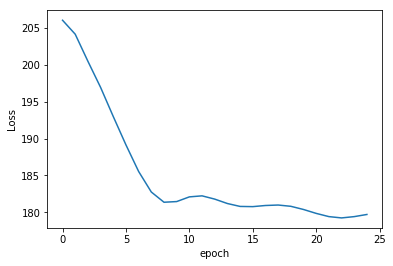

In [66]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    y_val = torch.flatten(y_val)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

In [90]:
raw_data_cat = final_data.copy().head(100000)
print(raw_data_cat.columns)

Index(['OP_CARRIER', 'ORIGIN', 'DEST', 'ARR_TIME', 'DISTANCE', 'FL_DATE_month', 'FL_DATE_weekday', 'TURNOVER_TIME', 'high_travel_days', 'is_summer', 'is_holiday', 'origin_city', 'destination_city', 'snow_amt_orig', 'rain_amt_orig', 'snow_amt_dest', 'rain_amt_dest'], dtype='object')


In [91]:
raw_data_cat['target_cat'] = 0
raw_data_cat.loc[raw_data_cat['TURNOVER_TIME'] < 0,'target_cat'] = 1
raw_data_cat = raw_data_cat.drop(columns = ['TURNOVER_TIME'])

print(raw_data_cat['target_cat'].value_counts())

0    76559
1    23441
Name: target_cat, dtype: int64


In [92]:
numerical_columns = ['ARR_TIME','DISTANCE','snow_amt_orig','rain_amt_orig','snow_amt_dest','rain_amt_dest']
ohe = ['OP_CARRIER','ORIGIN', 'DEST', ]
categorical_columns = ['high_travel_days','is_summer','is_holiday','FL_DATE_month','FL_DATE_weekday']

raw_data_cat.loc[raw_data_cat.high_travel_days == 0, 'high_travel_days'] = -1
raw_data_cat.loc[raw_data_cat.is_summer == 0, 'is_summer'] = -1
raw_data_cat.loc[raw_data_cat.is_holiday == 0, 'is_holiday'] = -1
raw_data_cat = categorize_dtype(raw_data_cat,categorical_columns)
raw_data_cat = dataprep_stsc(raw_data_cat,numerical_columns)

cat1 = raw_data_cat['high_travel_days'].cat.codes.values
cat2 = raw_data_cat['is_summer'].cat.codes.values
cat3 = raw_data_cat['is_holiday'].cat.codes.values
cat4 = raw_data_cat['FL_DATE_month'].cat.codes.values
cat5 = raw_data_cat['FL_DATE_weekday'].cat.codes.values

categorical_data = np.stack([cat1, cat2, cat3, cat4, cat5], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

numerical_data = np.stack([raw_data_cat[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

output = raw_data_cat.pop('target_cat')
outputs = torch.tensor(output.values).flatten()

print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

categorical_column_sizes = [len(raw_data_cat[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

total_records = len(raw_data_cat)
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

print(categorical_train_data.shape)
print(categorical_test_data.shape)
print(numerical_train_data.shape)
print(numerical_test_data.shape)
print(train_outputs.shape)
print(test_outputs.shape)

#__init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4)
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [100,50,10], p=0.4)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

print(model)

epochs = 15
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    #if i%25 == 1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

torch.Size([100000, 5])
torch.Size([100000, 6])
torch.Size([100000])
torch.Size([80000, 5])
torch.Size([20000, 5])
torch.Size([80000, 6])
torch.Size([20000, 6])
torch.Size([80000])
torch.Size([20000])
Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(1, 1)
    (2): Embedding(2, 1)
    (3): Embedding(1, 1)
    (4): Embedding(6, 3)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_f

epoch:  15 loss: 0.5558644533
Loss: 0.51876169


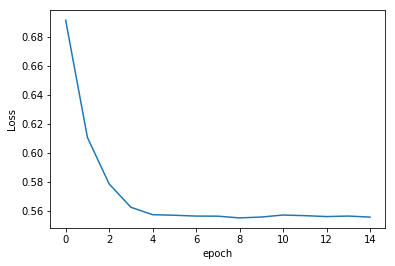

In [93]:
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')
y_val = np.argmax(y_val, axis=1)

In [94]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))


[[15780    17]
 [ 4202     1]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     15797
           1       0.06      0.00      0.00      4203

    accuracy                           0.79     20000
   macro avg       0.42      0.50      0.44     20000
weighted avg       0.64      0.79      0.70     20000

0.78905
